In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r "/content/drive/My Drive/datasets/Flicker8k_Dataset" "/content/"

In [3]:
!cp -r "/content/drive/My Drive/datasets/Flickr8k_text" "/content/"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add

In [5]:
with open("/content/drive/MyDrive/datasets/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [6]:
captions = captions.split("\n")[:-1]

In [7]:
len(captions)

40460

In [8]:
descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

##Data Cleaning

In [10]:
def clean_text(text):

  text = text.lower()
  text = re.sub("[^a-z]+"," ",text)
  text = text.split()
  text = [t for t in text if len(t)>1]
  text = " ".join(text)
  return text

In [11]:
for key,desc_list in descriptions.items():
  for i in range(len(desc_list)):
    desc_list[i] = clean_text(desc_list[i])

In [12]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
f = open("description.txt","w")
f.write(str(descriptions))
f.close

<function TextIOWrapper.close()>

In [14]:
f = open("description.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

unique words in vocab

In [15]:
vocab = set()
for key in descriptions.keys():
  [vocab.update(i.split()) for i in descriptions[key]]

print("vocab size: %d" % len(vocab))

vocab size: 8424


reduce vocab size

In [16]:
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))

Vocabulary Size: 373837


In [17]:
import collections

counter = collections.Counter(all_vocab)

dic = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [18]:
len(all_vocab)

1845

In [19]:
sorted_dic[:5]

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863)]

##Loading training dataset

In [20]:
f = open("Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [21]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [22]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [23]:
f = open("Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [24]:
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [25]:
train_descriptions = {}

for i in train:
  train_descriptions[i] = []
  for cap in descriptions[i]:
    cap_ = "startseq " + cap + " endseq"
    train_descriptions[i].append(cap_)

In [26]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

##Data Preprocessing Image

In [27]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [28]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
model_new = Model(model.input, model.layers[-2].output)

In [63]:
images = "Flicker8k_Dataset/"

In [31]:
len(images)

18

In [32]:
def preprocess_image(img):
    img = load_img(img, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [33]:
def encode_image(img):
  img = preprocess_image(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape(feature_vector.shape[1],)
  return feature_vector

In [34]:
start = time()
encoding_train = {}

for i, img in enumerate(train):
    
    img = "Flicker8k_Dataset/{}.jpg".format(train[i])
    encoding_train[img[len(images):]] = encode_image(img)
    
    
print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step
Time taken in seconds = 583.4406590461731


In [35]:
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [36]:
start = time()

encoding_test = {}

for i, img in enumerate(test):

    img = "Flicker8k_Dataset/{}.jpg".format(test[i])
    encoding_test[img[len(images):]] = encode_image(img)
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 38ms/step
Time taken in seconds = 81.04016733169556


In [37]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [38]:
with open("encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [39]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [40]:
# encoding_train['.jpg']

In [41]:
# encoding_train.keys()

dict_keys(['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '6971

In [42]:
# len(encoding_train['.jpg'])

##Data preprocessing Captions

In [43]:
i = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = i
    idx_to_word[i] = e
    i +=1

In [44]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [45]:
vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [46]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


##Data Preparation using Generator Function


In [47]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [48]:
!cp -r "/content/drive/My Drive/datasets/glove.6B.50d.txt" "/content/"

In [49]:
f = open("glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

##Converting words into vectors Directly - (Embedding Layer Output)


In [50]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [51]:
embedding_output.shape

(1848, 50)

##Model Architecture

In [52]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [53]:
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [54]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [56]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [57]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

##Training our model

In [58]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [59]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

2000/2000 [==============================] - 29s 14ms/step - loss: 2.7784


In [60]:
model = load_model("model_weights/model_9.h5")


##Predictions

In [65]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence],verbose=0)
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

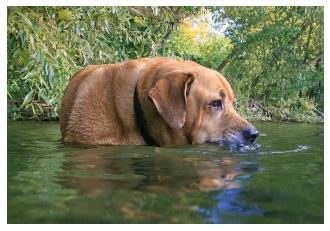

brown dog is running through the grass


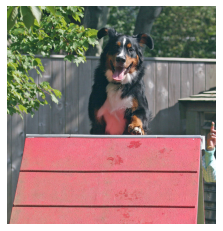

black and white dog is running on the grass


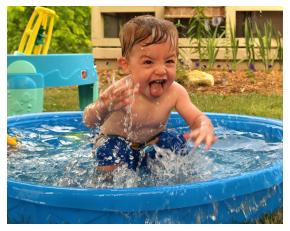

boy in pool with water wings in his hand


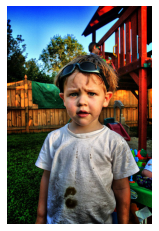

boy in red shirt is sitting on the grass


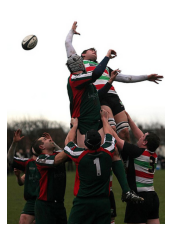

two men in athletic uniforms are playing soccer


In [66]:
for i in range(5):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)